In [ ]:
# ライブラリーを読み込む
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

# MNISTデータをダウンロード
dataset = torchvision.datasets.MNIST(root="./data",
                                           train=True,
                                           transform=transform,
                                           download=True)

# 10000枚を評価用(valid_dataset)、50000枚を学習用(train_dataset)に分ける
valid_dataset = Subset(dataset, torch.arange(10000))
train_dataset = Subset(dataset, torch.arange(10000, len(dataset)))

# テストデータをダウンロード
test_dataset = torchvision.datasets.MNIST(root="./data",
                                           train=False,
                                           transform=transform,
                                           download=False)

In [ ]:
# バッチサイズを64にする
batch_size = 64
torch.manual_seed(1)

# バッチサイズごとにデータを読み込むようにする
# 学習データはランダムにシャッフルする
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size, shuffle=False)

In [ ]:
# 階層型ニューラルネットワークのオブジェクトを作成
model = nn.Sequential()

# 畳み込み層を追加（入力のチャネル数１、出力のチャネル数32、カーネルの幅5、パディング2）
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
# 活性化関数としてReLUを追加
model.add_module('relu1', nn.ReLU())
# 最大プーリング層を追加（カーネルサイズ2）
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

# 畳み込み層、ReLU、最大プーリング層を追加
# ただし、畳み込み層の入力のチャネル数32、出力のチャネル数64
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

# 平坦化
model.add_module('flatten', nn.Flatten())

# 全結合層を追加 3136 => 10
model.add_module('fc1', nn.Linear(3136, 10))
# Softmax関数を追加し、最終出力とする
model.add_module('softmax', nn.Softmax(dim=1))

In [ ]:
# GPUを使う設定
device = torch.device("cuda")

# GPUにモデルを転送
model = model.to(device)

In [ ]:
# エポック数を10に設定
num_epochs = 10

# 学習率を0.001に設定
learning_ratio = 0.001

torch.manual_seed(1)

# 交差エントロピー誤差を使用
loss_fn = nn.CrossEntropyLoss()

# Adamオプティマイザーを使用
optimizer = torch.optim.Adam(model.parameters(), lr=learning_ratio)

loss_hist_train = np.zeros(num_epochs)
accuracy_hist_train = np.zeros(num_epochs)
loss_hist_valid = np.zeros(num_epochs)
accuracy_hist_valid = np.zeros(num_epochs)

for epoch in range(num_epochs):

    # 学習モードに切り替え
    model.train()

    # 学習データを使って、学習する
    for x_batch, y_batch in train_dl:

        # GPUにデータを転送
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(y_pred, dim=1) == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.sum().cpu()

    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)

    # 評価モードに切り替え
    model.eval()

    # 評価データを使って、学習結果を評価する
    with torch.no_grad():
        for x_batch, y_batch in valid_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(y_pred, dim=1) == y_batch).float()
            accuracy_hist_valid[epoch] += is_correct.sum().cpu()

    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

    # エポックごとの正解率を表示
    print(f'Epoch: {epoch+1}, Accuracy(train): {accuracy_hist_train[epoch]:.4f}, Accuracy(valid): {accuracy_hist_valid[epoch]:.4f}')

Epoch: 1, Accuracy(train): 0.9221, Accuracy(valid): 0.9698
Epoch: 2, Accuracy(train): 0.9784, Accuracy(valid): 0.9785
Epoch: 3, Accuracy(train): 0.9835, Accuracy(valid): 0.9845
Epoch: 4, Accuracy(train): 0.9858, Accuracy(valid): 0.9842
Epoch: 5, Accuracy(train): 0.9889, Accuracy(valid): 0.9846
Epoch: 6, Accuracy(train): 0.9903, Accuracy(valid): 0.9867
Epoch: 7, Accuracy(train): 0.9913, Accuracy(valid): 0.9861
Epoch: 8, Accuracy(train): 0.9913, Accuracy(valid): 0.9884
Epoch: 9, Accuracy(train): 0.9927, Accuracy(valid): 0.9863
Epoch: 10, Accuracy(train): 0.9934, Accuracy(valid): 0.9893


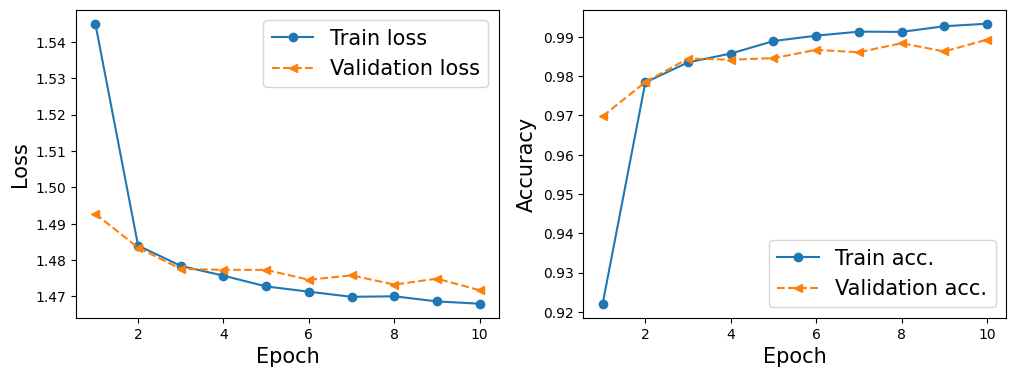

In [ ]:
# 横軸の値を用意
x_arr = np.arange(1, num_epochs+1)

fig = plt.figure(figsize=(12, 4))

# 誤差をプロット
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, loss_hist_train, '-o', label='Train loss')
ax.plot(x_arr, loss_hist_valid, '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

# 正解率をプロット
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, accuracy_hist_train, '-o', label='Train acc.')
ax.plot(x_arr, accuracy_hist_valid, '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
# テストデータを使って、性能を評価
torch.cuda.synchronize()
model_cpu = model.cpu()
pred = model_cpu(test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9908


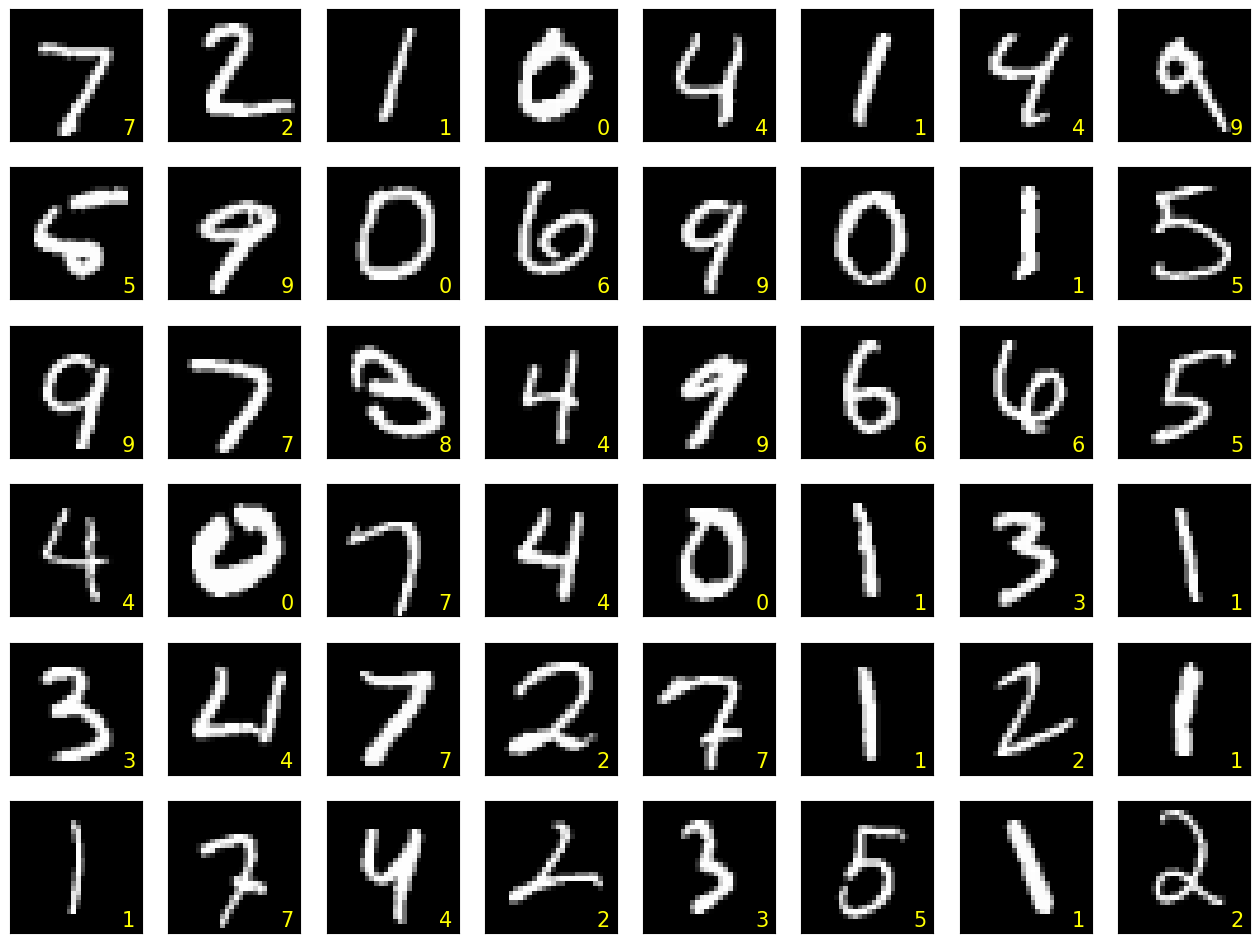

In [ ]:
fig = plt.figure(figsize=(16, 12))
for i in range(48):
    ax = fig.add_subplot(6, 8, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = test_dataset[i][0][0, :, :]
    pred = model_cpu(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray')
    ax.text(0.9, 0.1, y_pred.item(),
            size=15, color='yellow',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
plt.show()